array([<AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>, <AxesSubplot:xlabel='Timestamp'>,
       <AxesSubplot:xlabel='Timestamp'>], dtype=object)

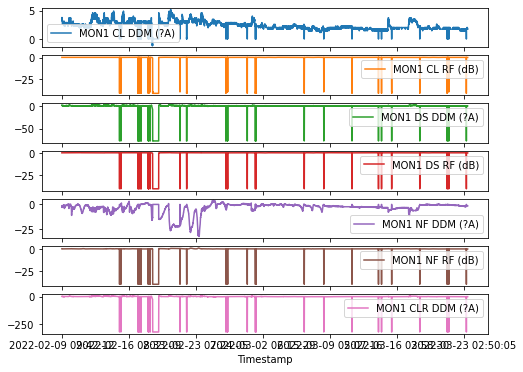

In [8]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

df = pd.read_csv('FormattedData/train.csv', sep = ',' , header=0)

df.head()

#Format datetime
df.index = pd.to_datetime(df['Timestamp'].astype('datetime64').astype(int).astype(float), format='%Y-%m-%d %H:%M:%S')

TRAIN_SPLIT = 2000

tf.random.set_seed(13)

#Which features in dataset to consider
features_considered = ['MON1 CL DDM (?A)', 'MON1 CL RF (dB)', 'MON1 DS DDM (?A)', 'MON1 DS RF (dB)', 'MON1 NF DDM (?A)', 'MON1 NF RF (dB)' , 'MON1 CLR DDM (?A)']

features = df[features_considered]
features.index = df['Timestamp']
features.head()

features.plot(subplots=True)


In [11]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset.iloc[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [12]:
past_history = 500
future_target = 72
STEP = 6

x_train_multi, y_train_multi = multivariate_data(df, df.iloc[:, 1], 0, TRAIN_SPLIT, past_history, future_target, STEP)

x_val_multi, y_val_multi = multivariate_data(df, df.iloc[:, 1], TRAIN_SPLIT, None, past_history, future_target, STEP)

In [13]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

2022-04-21 10:57:57.035499: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-21 10:57:57.035683: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-21 10:57:57.035731: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-8JQCUIJ): /proc/driver/nvidia/version does not exist
2022-04-21 10:57:57.037524: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [18]:
def create_time_steps(length):
  return list(range(-length, 0))

In [19]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

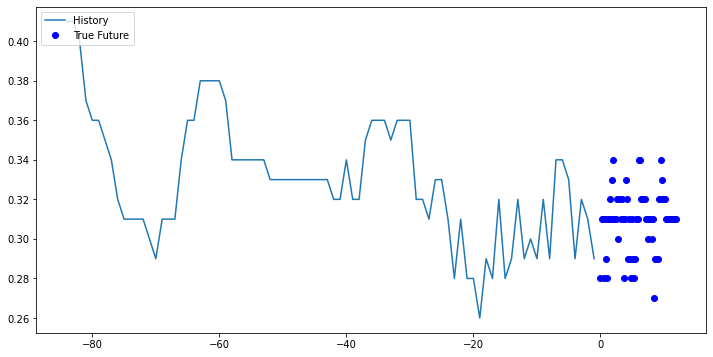

In [20]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [22]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [23]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [24]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 21s 89ms/step - loss: 0.2034 - val_loss: 1.6807
Epoch 2/10
200/200 [==============================] - 20s 102ms/step - loss: 0.1632 - val_loss: 1.6787
Epoch 3/10
200/200 [==============================] - 22s 111ms/step - loss: 0.1619 - val_loss: 1.6728
Epoch 4/10
200/200 [==============================] - 19s 96ms/step - loss: 0.1606 - val_loss: 1.6704
Epoch 5/10
200/200 [==============================] - 19s 96ms/step - loss: 0.1597 - val_loss: 1.6732
Epoch 6/10
200/200 [==============================] - 21s 105ms/step - loss: 0.1590 - val_loss: 1.6764
Epoch 7/10
200/200 [==============================] - 21s 106ms/step - loss: 0.1578 - val_loss: 1.6749
Epoch 8/10
200/200 [==============================] - 19s 94ms/step - loss: 0.1577 - val_loss: 1.6788
Epoch 9/10
200/200 [==============================] - 19s 97ms/step - loss: 0.1559 - val_loss: 1.6830
Epoch 10/10
200/200 [==============================] - 20s 98ms/step - loss: 0

In [26]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

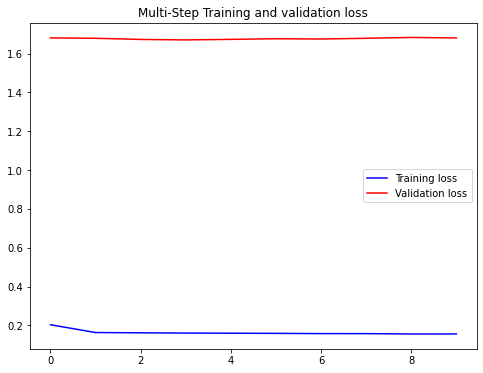

In [27]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

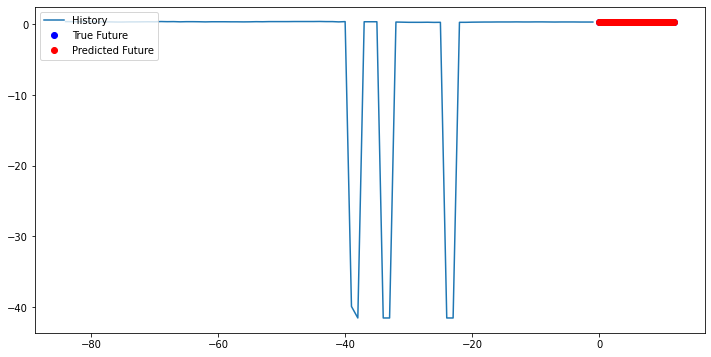

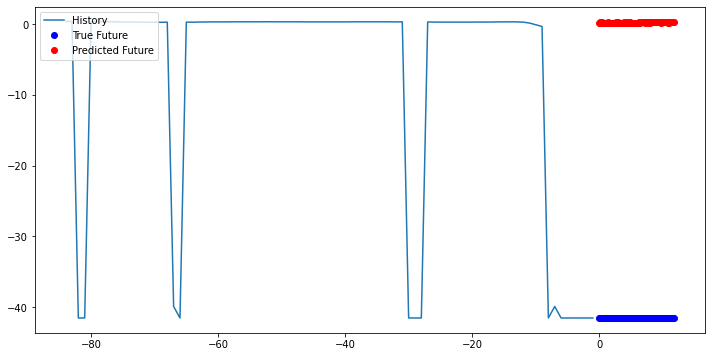

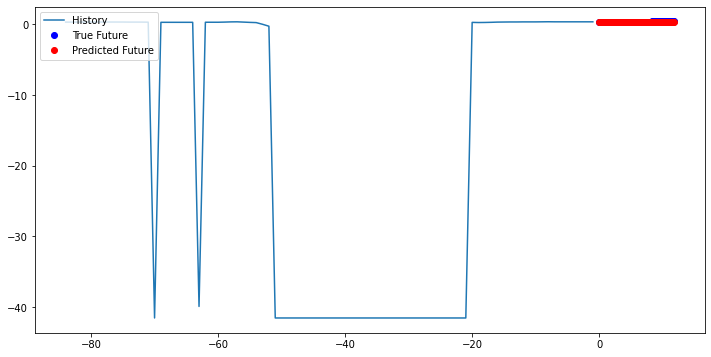

In [28]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])